In [2]:
import numpy as np
import matlab.engine
import math

mle = matlab.engine.start_matlab('-desktop')

In [92]:
#how to call
tunableParams = {
    'current_height': 4700.0,
    'current_vel':260.0,
    'current_pitch':0.0,
    'extension_length':0.0
}
results = mle.sim_the_model('Stoptime',STOP_TIME,"StartTime",START_TIME,'TunableParameters',tunableParams)

mle.quit()

In [3]:
def getApogee(result_matlab):
    velocity_data = result_matlab['velocity']['Data']
    velocity_time = result_matlab['velocity']['Time']
    height_data = result_matlab['height']['Data']
    height_time = result_matlab['height']['Time']

    #find time when apogee hit
    apogee_index = -1
    for i in range(0,len(velocity_data)):
        if (velocity_data[i][0]<=0 and i>1):
            apogee_index = i
            break
            
    if (apogee_index != -1):
        #find time when apogee hit
        apogee_time = velocity_time[apogee_index][0]
        return height_data[apogee_index][0]
    else:
        return -1 #INVALID APOGEE
    

In [94]:
print(getApogee(results))

7305.876945744813


In [71]:
#No airbrake deployment
#max height: 7092m
#height at burn out: 1500m
#vel at burnout: 620m/s


vel: 260 -> 0
height: 4700 -> 7092
extension: 0.0 -> 0.025 (lookup table in int percentage)

(261 x 241) lookup table

_ h   4700 4710 4720 ... 7100
v
260
259
258
.
.
.
0

mini version: (27 x 25)
____  h   4700 4800 4900 ... 7100
v
260
250
240
230
.
.
0

In [4]:
MAX_EXTENSION = 0.025
ERROR_THRESHOLD = 1
TARGET_APOG = 6850
STOP_TIME = 34
START_TIME = 5
MAX_CALLS = 10

In [5]:
def get_extension(curr_vel, curr_alt,target):
    #find apogee when no extension yet
    params = {
        'current_height': curr_alt,
        'current_vel':curr_vel,
        'current_pitch':0.0,
        'extension_length':0.0
    }
    result = mle.sim_the_model('Stoptime',STOP_TIME,"StartTime", START_TIME,'TunableParameters',params)
    curr_apog = getApogee(result)
    print("curr apogee w no extension = " + str(curr_apog))
    
    #already undershooting
    if curr_apog<target:
        return 0

    params['extension_length']= MAX_EXTENSION
    result = mle.sim_the_model('Stoptime',STOP_TIME,"StartTime", START_TIME,'TunableParameters',params)
    curr_apog = getApogee(result)
    print("curr apogee w 100% extension = " + str(curr_apog))

    #already undershooting
    if curr_apog>target:
        return 100

    #find best extension w binary search
    low = 0
    hi = 100
    num_calls = 0
    
    while (low<hi and num_calls<MAX_CALLS):
        print("doing a BS")
        mid = (low+hi)/2
        params['extension_length']= (mid/100.0)*MAX_EXTENSION
        result = mle.sim_the_model('Stoptime',STOP_TIME,"StartTime", START_TIME,'TunableParameters',params)
        curr_apog = getApogee(result)
        if (abs(curr_apog-target)<=ERROR_THRESHOLD):
            return math.floor(mid)
        elif (curr_apog<target):
            #smaller extension
            hi = mid
        else:
            low=mid
        num_calls+=1
    return 0

In [6]:
LUT = [[0]*25 for _ in range(27)]

In [7]:
for i in range(0,27):
    for j in range(0,25):
        vel = float(260 - i*10)
        height = float(4700 + j*100)
        try:
            curr_extension = get_extension(vel,height,TARGET_APOG)
        except:
            curr_extension = -1
        LUT[i][j] = curr_extension
        print("vel: "+str(vel) + " height: "+str(height) + " extension: " + str(curr_extension))

curr apogee w no extension = 7305.876945744813
curr apogee w 100% extension = 7304.200383381849
vel: 260.0 height: 4700.0 extension: 100
curr apogee w no extension = 7404.622344626994
curr apogee w 100% extension = 7402.942928713979
vel: 260.0 height: 4800.0 extension: 100
curr apogee w no extension = 7503.360594832723
curr apogee w 100% extension = 7501.678318440411
vel: 260.0 height: 4900.0 extension: 100
curr apogee w no extension = 7602.091499596666
curr apogee w 100% extension = 7600.4063600478785
vel: 260.0 height: 5000.0 extension: 100
curr apogee w no extension = 7700.8148416759095
curr apogee w 100% extension = 7699.126832209274
vel: 260.0 height: 5100.0 extension: 100
curr apogee w no extension = 7799.530417572242
curr apogee w 100% extension = 7797.839531584192
vel: 260.0 height: 5200.0 extension: 100
curr apogee w no extension = 7898.237982322136
curr apogee w 100% extension = 7896.5442173987
vel: 260.0 height: 5300.0 extension: 100
curr apogee w no extension = 7996.9373214

In [9]:
import pickle
file_table = open('lut_mini.pickle', 'wb')
pickle.dump(LUT,file_table)
file_table.close()

In [10]:
with open('lut_mini.pickle','rb') as f:
    get_lut = pickle.load(f)

In [12]:
print(get_lut)

[[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100], [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100], [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100], [0, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100], [0, 0, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100], [0, 0, 0, 0, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100], [0, 0, 0, 0, 0, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100], [0, 0, 0, 0, 0, 0, 0, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100], [0, 0, 0, 0, 0, 0, 0,

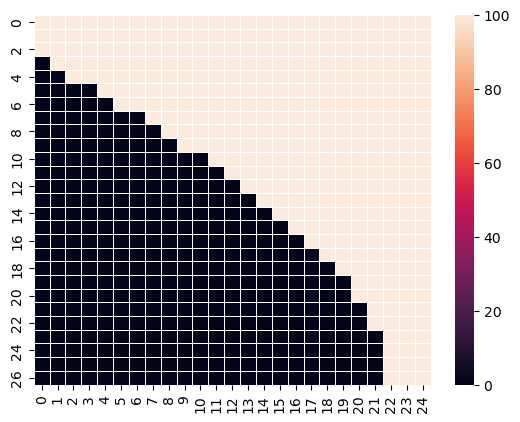

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

lut_np = np.array(get_lut)
ax = sns.heatmap(lut_np, linewidth=0.5)
plt.show()

<Axes: title={'center': 'mini lookup table draft'}>

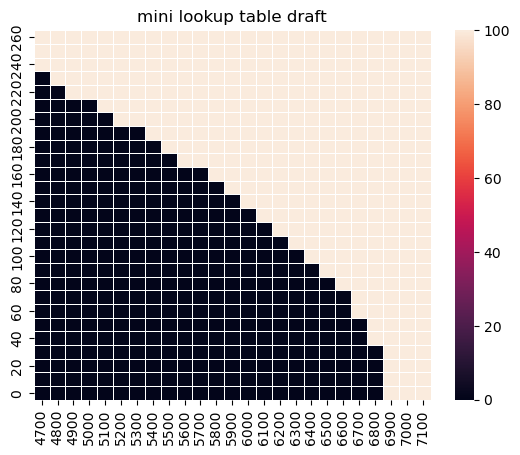

In [23]:
label_vel = [260 - i*10 for i in range(0,27)]
label_height = [4700 + j*100 for j in range(0,25)]
lut_pd = pd.DataFrame(get_lut, index = label_vel, columns = label_height)
plt.title('mini lookup table draft')
plt.xlabel('height (m)')
plt.ylabel('velocity (m/s')
sns.heatmap(lut_pd, annot=False, linewidth=0.5)

In [114]:
#try first entry: height = 4700, vel = 260
%timeit print(get_extension(260.0,4700.0,TARGET_APOG))

curr apogee w no extension = 7305.876945744813
curr apogee w 100% extension = 7304.200383381849
100
curr apogee w no extension = 7305.876945744813
curr apogee w 100% extension = 7304.200383381849
100
curr apogee w no extension = 7305.876945744813
curr apogee w 100% extension = 7304.200383381849
100
curr apogee w no extension = 7305.876945744813
curr apogee w 100% extension = 7304.200383381849
100
curr apogee w no extension = 7305.876945744813
curr apogee w 100% extension = 7304.200383381849
100
curr apogee w no extension = 7305.876945744813
curr apogee w 100% extension = 7304.200383381849
100
curr apogee w no extension = 7305.876945744813
curr apogee w 100% extension = 7304.200383381849
100
curr apogee w no extension = 7305.876945744813
curr apogee w 100% extension = 7304.200383381849
100
479 ms ± 84.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [76]:
mle.quit()

479 ms per call min
30129 s
8.4 hrs to generate whole table :( fun